In [1]:
%matplotlib inline
import math

import numpy as np
import time
import matplotlib.pyplot as plt

from tools.corner_response_function import compute_gaussian_grad,compute_corner_response
from tools.visualization import reshape_as_images, imshow
from tools.data_loading import load_images
from tools.discretization import discretize_orientation, pin_as_vect
from tools.quantization import kmeans, vf_vector

In [2]:
filter_size = 3

In [3]:
X = load_images(type="train")
X = reshape_as_images(X) # 4500 x 32 x 32 x 3
images = X.mean(axis=3) # 4500 x 32 x 32
window_size = 5
stride = 3
patch_size = 5
pins = list()

R_size = (images.shape[1] - window_size - filter_size)//stride + 1
R = np.zeros((images.shape[0], R_size, R_size))

In [4]:
for image_idx in range(images.shape[0]):
        image_mat = images[image_idx]
        im_size = image_mat.shape[0]  # normally 32
        image_grad_x, image_grad_y = compute_gaussian_grad(image_mat)

        for i in range(R_size):
            for j in range(R_size):
                I_x = image_grad_x[i*stride:i*stride+window_size,
                                   j*stride:j*stride+window_size]
                I_y = image_grad_y[i*stride:i*stride+window_size,
                                   j*stride:j*stride+window_size]

                R[image_idx, i, j] = compute_corner_response(I_x, I_y)
        # thresholding of R
        R[image_idx] = np.abs(R[image_idx])

In [5]:
def from_R_to_im(x, y, window_size, stride):
    x = x * stride + (window_size - 1)//2 + (filter_size - 1)//2
    y = y * stride + (window_size - 1)//2 + (filter_size - 1)//2

    return (x, y)


def R_to_heatmap(R, window_size, stride, im_size):
    R_size = R.shape[0]
    # create heatmap
    heatmap = np.zeros((im_size, im_size))
    for i in range(R_size):
        for j in range(R_size):
            ix, iy = from_R_to_im(i, j, window_size, stride)
            heatmap[ix:ix+window_size,
                    iy:iy+window_size] = R[i, j]
    heatmap /= heatmap.max()
    return heatmap

In [6]:
ind = 0

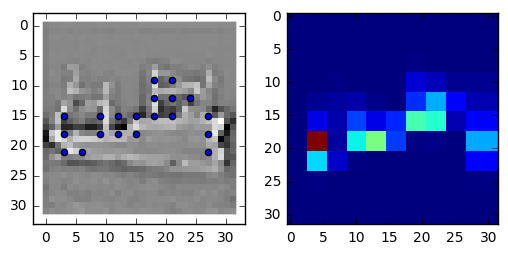

In [7]:
i, j = np.where(R[ind] > np.percentile(R[ind], 75))
i, j = from_R_to_im(i, j, window_size, stride)

x, y = j, i

heatmap = R_to_heatmap(R[ind], window_size, stride, im_size)
imshow(images[ind], points_of_interest=(x, y), heatmap=heatmap)
ind +=1

In [8]:
pins_img_ids = []
pins_coords = []
for image_idx in range(images.shape[0]):
    i_s, j_s = np.where(
        R[image_idx] > np.percentile(R[image_idx], 75))
    i_s, j_s = from_R_to_im(i_s, j_s, window_size, stride)
    for i, j in zip(i_s, j_s):  # i, j are the coordinates in R of POI
        patch_x = image_grad_x[i-patch_size//2:i+patch_size//2+1,
                               j-patch_size//2:j+patch_size//2+1]
        patch_y = image_grad_y[i-patch_size//2:i+patch_size//2+1,
                               j-patch_size//2:j+patch_size//2+1]
        pin_as_matrix = discretize_orientation(patch_x, patch_y)
        pin = pin_as_vect(pin_as_matrix)
        pins.append(pin)
        # for visualization purposes
        pins_img_ids.append(image_idx)
        pins_coords.append((i,j))

In [9]:
len(pins_img_ids)

100000

In [10]:
pins_mat = np.vstack(pins)

In [11]:
visual_features = kmeans(pins_mat, 66)

97515
0


In [12]:
vf_vector(pins, visual_features)

array([ 2485.,  1501.,  1475.,  1504.,  1719.,  1084.,  1403.,   827.,
        1275.,  1006.,  2594.,  2669.,  1199.,  1774.,  1521.,  1748.,
        1615.,  1359.,  1823.,  1685.,  2367.,  1309.,   706.,  1115.,
         935.,   999.,   959.,  1572.,  1082.,  1212.,  2923.,  1117.,
        3629.,  1502.,   692.,  1826.,  1508.,  1152.,   796.,  1599.,
        2306.,  1764.,  2461.,  2583.,   799.,   951.,  1319.,  3408.,
        1446.,  2154.,  1115.,  1443.,  1333.,  2198.,   799.,  1667.,
        1235.,   771.,  1072.,  1249.,   793.,  1317.,  1061.,   801.,
        1773.,   916.])

AttributeError: Unknown property interploation

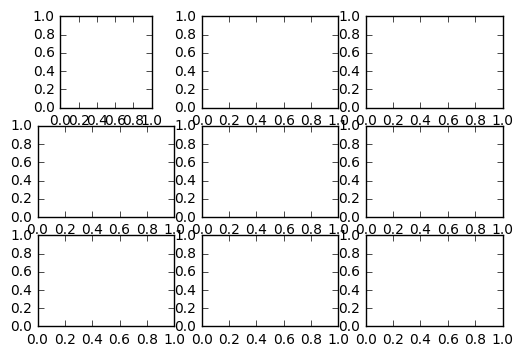

In [21]:
##### Vizu des bovf !
pins = np.vstack(pins)

y = np.argmin(np.linalg.norm(pins[:, None, :] - visual_features, axis=2), axis=1)


nb_features = 3
for i in range(nb_features): # first three visual features
    indices = np.where(y == i)[0][:9]
    f, axarr = plt.subplots(3, 3)
    
    for aa in range(9):
        r = aa // 3
        s = aa - r * 3
        ii, jj = pins_coords[indices[aa]]
        image = X[pins_img_ids[indices[aa]]][ii-patch_size//2:ii+patch_size//2+1,
                               jj-patch_size//2:jj+patch_size//2+1]
        image -= X[pins_img_ids].min()
        image /= X[pins_img_ids].max()
        axarr[r,s].imshow(image, interpolation="nearest")
    f.show()